## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
65 // 2

32

In [2]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [3]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [4]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [5]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [6]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [7]:
import segmentation_models_pytorch as smp

In [8]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [9]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp025b'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [12]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [13]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [14]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [15]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    # mid = 65 // 2
    mid = 36 # https://www.kaggle.com/code/ajland/eda-a-slice-by-slice-analysis
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [16]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [17]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [18]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [19]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [20]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [21]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [22]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

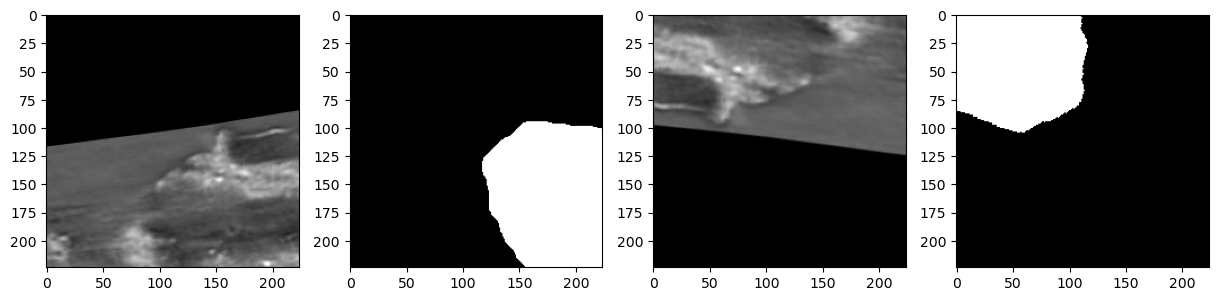

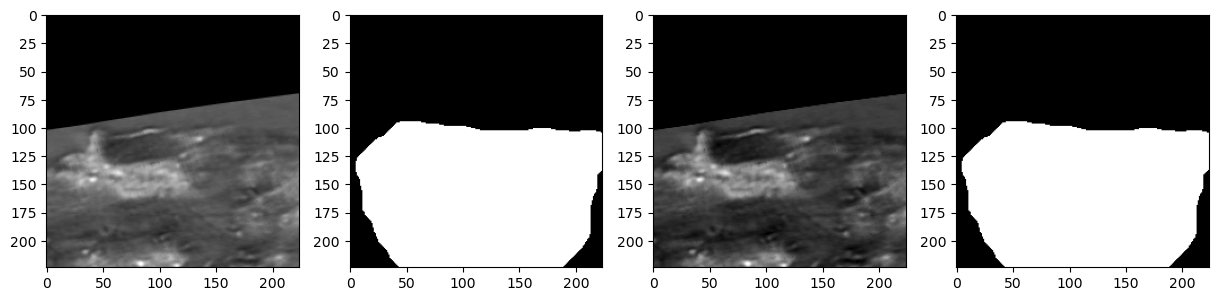

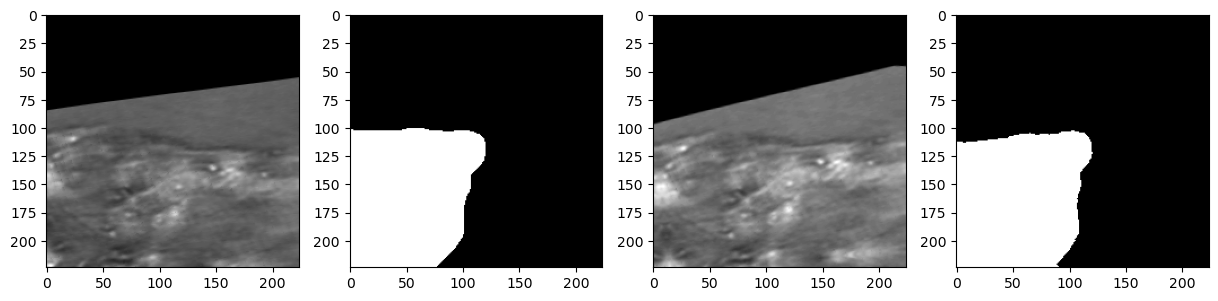

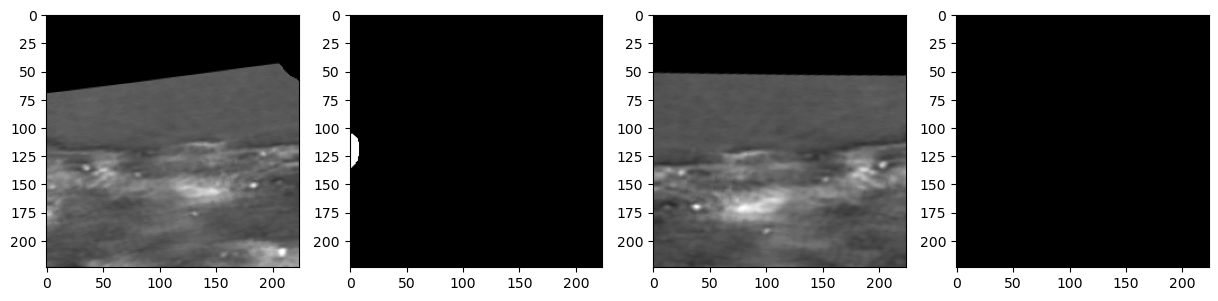

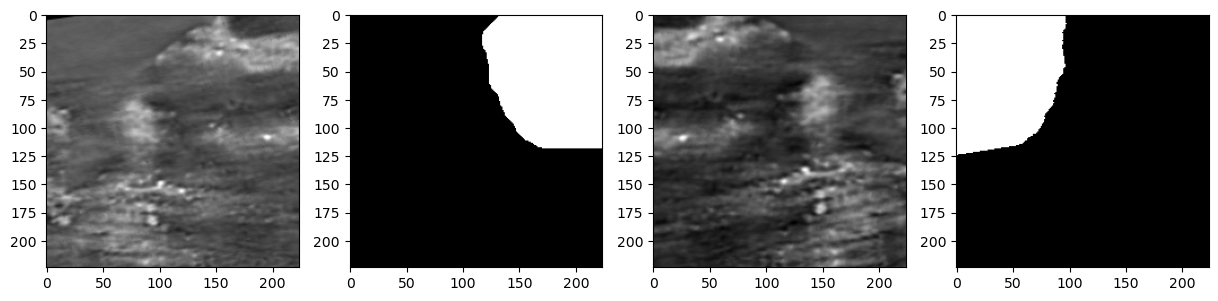

In [23]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [24]:
del plot_dataset
gc.collect()

48125

## model

In [25]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [26]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [27]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [28]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [29]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [30]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [31]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [32]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [33]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [34]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1416515366604961
th: 0.15, fbeta: 0.14153253613655942
th: 0.2, fbeta: 0.14119515306712022
th: 0.25, fbeta: 0.14047755140933277
th: 0.3, fbeta: 0.19031831176221473
th: 0.35, fbeta: 0.2078783341503775
th: 0.4, fbeta: 0.216585163750617
th: 0.45, fbeta: 0.2229997921000849


best_th: 0.45, fbeta: 0.2229997921000849
Epoch 1 - avg_train_loss: 0.6608  avg_val_loss: 0.5296  time: 116s
Epoch 1 - avgScore: 0.2230
Epoch 1 - Save Best Score: 0.2230 Model
Epoch 1 - Save Best Loss: 0.5296 Model


th: 0.5, fbeta: 0.21863177443439763


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14169781687395788
th: 0.15, fbeta: 0.14165608411984745
th: 0.2, fbeta: 0.18944174148371457
th: 0.25, fbeta: 0.20655703128112532
th: 0.3, fbeta: 0.23383984529634133
th: 0.35, fbeta: 0.24280336327062546
th: 0.4, fbeta: 0.2187978157695559
th: 0.45, fbeta: 0.1710924426725663


best_th: 0.35, fbeta: 0.24280336327062546
Epoch 2 - avg_train_loss: 0.4517  avg_val_loss: 0.4117  time: 117s
Epoch 2 - avgScore: 0.2428
Epoch 2 - Save Best Score: 0.2428 Model
Epoch 2 - Save Best Loss: 0.4117 Model


th: 0.5, fbeta: 0.12048965534761479


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.23164221566455914
th: 0.15, fbeta: 0.25541311541537
th: 0.2, fbeta: 0.19655556718762407
th: 0.25, fbeta: 0.13504695322323013
th: 0.3, fbeta: 0.088058355644287
th: 0.35, fbeta: 0.054824047461850156
th: 0.4, fbeta: 0.03082842499861734
th: 0.45, fbeta: 0.015745994654206317


best_th: 0.15, fbeta: 0.25541311541537
Epoch 3 - avg_train_loss: 0.3023  avg_val_loss: 0.3360  time: 116s
Epoch 3 - avgScore: 0.2554
Epoch 3 - Save Best Score: 0.2554 Model
Epoch 3 - Save Best Loss: 0.3360 Model


th: 0.5, fbeta: 0.008351359546507502


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.236703920566941
th: 0.15, fbeta: 0.1874568802059923
th: 0.2, fbeta: 0.11477299861525328
th: 0.25, fbeta: 0.06233455449573662
th: 0.3, fbeta: 0.03368546962534973
th: 0.35, fbeta: 0.017762403681306316
th: 0.4, fbeta: 0.009668559390974277
th: 0.45, fbeta: 0.006098240257007791


best_th: 0.1, fbeta: 0.236703920566941
Epoch 4 - avg_train_loss: 0.2352  avg_val_loss: 0.3555  time: 117s
Epoch 4 - avgScore: 0.2367


th: 0.5, fbeta: 0.003704213391007349


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3068898628839018
th: 0.15, fbeta: 0.3493501359905772
th: 0.2, fbeta: 0.33405604683225554
th: 0.25, fbeta: 0.2834674265596452
th: 0.3, fbeta: 0.21756418694724577
th: 0.35, fbeta: 0.1665375347688216
th: 0.4, fbeta: 0.12560880270374705
th: 0.45, fbeta: 0.09084012559949715


best_th: 0.15, fbeta: 0.3493501359905772
Epoch 5 - avg_train_loss: 0.2176  avg_val_loss: 0.3398  time: 117s
Epoch 5 - avgScore: 0.3494
Epoch 5 - Save Best Score: 0.3494 Model
Epoch 5 - Save Best Loss: 0.3398 Model


th: 0.5, fbeta: 0.06224174955839779


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30583918930462517
th: 0.15, fbeta: 0.2580542363712003
th: 0.2, fbeta: 0.21222945200938745
th: 0.25, fbeta: 0.16641844513314194
th: 0.3, fbeta: 0.13178805073237615
th: 0.35, fbeta: 0.10461803485007677
th: 0.4, fbeta: 0.08046792526195515
th: 0.45, fbeta: 0.0617347529306415


best_th: 0.1, fbeta: 0.30583918930462517
Epoch 6 - avg_train_loss: 0.2039  avg_val_loss: 0.4494  time: 117s
Epoch 6 - avgScore: 0.3058


th: 0.5, fbeta: 0.04697667526173414


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2908287669833145
th: 0.15, fbeta: 0.2841884960557811
th: 0.2, fbeta: 0.27239159542864844
th: 0.25, fbeta: 0.2529021424049603
th: 0.3, fbeta: 0.22695319599709562
th: 0.35, fbeta: 0.19770792587542946
th: 0.4, fbeta: 0.16614349946922596
th: 0.45, fbeta: 0.13627240357704437


best_th: 0.1, fbeta: 0.2908287669833145
Epoch 7 - avg_train_loss: 0.1955  avg_val_loss: 0.4427  time: 117s
Epoch 7 - avgScore: 0.2908


th: 0.5, fbeta: 0.10761643442871231


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32854195944181247
th: 0.15, fbeta: 0.35240027890918246
th: 0.2, fbeta: 0.3566427799564155
th: 0.25, fbeta: 0.3468083208914952
th: 0.3, fbeta: 0.3246868242411296
th: 0.35, fbeta: 0.2910676412321129
th: 0.4, fbeta: 0.25162122818342836
th: 0.45, fbeta: 0.20880157523463727


best_th: 0.2, fbeta: 0.3566427799564155
Epoch 8 - avg_train_loss: 0.1836  avg_val_loss: 0.3577  time: 117s
Epoch 8 - avgScore: 0.3566
Epoch 8 - Save Best Score: 0.3566 Model
Epoch 8 - Save Best Loss: 0.3577 Model


th: 0.5, fbeta: 0.1674694323394644


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2994632118342637
th: 0.15, fbeta: 0.2804984682537983
th: 0.2, fbeta: 0.2549919783787289
th: 0.25, fbeta: 0.2283223813747359
th: 0.3, fbeta: 0.20099638962478014
th: 0.35, fbeta: 0.17521673587758238
th: 0.4, fbeta: 0.14956998811340477
th: 0.45, fbeta: 0.12477636057692935


best_th: 0.1, fbeta: 0.2994632118342637
Epoch 9 - avg_train_loss: 0.1750  avg_val_loss: 0.4936  time: 117s
Epoch 9 - avgScore: 0.2995


th: 0.5, fbeta: 0.1011648020102879


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29749003353890746
th: 0.15, fbeta: 0.30578877262976456
th: 0.2, fbeta: 0.308515913813813
th: 0.25, fbeta: 0.3061524052476141
th: 0.3, fbeta: 0.30074104496098614
th: 0.35, fbeta: 0.29442630383117335
th: 0.4, fbeta: 0.2844932214621374
th: 0.45, fbeta: 0.2690523218156901


best_th: 0.2, fbeta: 0.308515913813813
Epoch 10 - avg_train_loss: 0.1638  avg_val_loss: 0.3983  time: 117s
Epoch 10 - avgScore: 0.3085


th: 0.5, fbeta: 0.2501043702437239


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31997044143037906
th: 0.15, fbeta: 0.3149845513860644
th: 0.2, fbeta: 0.30649448473990065
th: 0.25, fbeta: 0.2929128976206546
th: 0.3, fbeta: 0.27582599516819073
th: 0.35, fbeta: 0.25761276393563143
th: 0.4, fbeta: 0.2381171562741317
th: 0.45, fbeta: 0.21637726152125963


best_th: 0.1, fbeta: 0.31997044143037906
Epoch 11 - avg_train_loss: 0.1528  avg_val_loss: 0.4998  time: 117s
Epoch 11 - avgScore: 0.3200


th: 0.5, fbeta: 0.19381703906161543


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2868574783295291
th: 0.15, fbeta: 0.27324767807494743
th: 0.2, fbeta: 0.2588470041545933
th: 0.25, fbeta: 0.24026710726309247
th: 0.3, fbeta: 0.2194185105879052
th: 0.35, fbeta: 0.19607311197690366
th: 0.4, fbeta: 0.17059656515925078
th: 0.45, fbeta: 0.1464771127419745


best_th: 0.1, fbeta: 0.2868574783295291
Epoch 12 - avg_train_loss: 0.1444  avg_val_loss: 0.5340  time: 117s
Epoch 12 - avgScore: 0.2869


th: 0.5, fbeta: 0.1230531757231757


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3322507376113633
th: 0.15, fbeta: 0.34199501772614727
th: 0.2, fbeta: 0.34647779224161385
th: 0.25, fbeta: 0.3470940705510355
th: 0.3, fbeta: 0.3434097124553896
th: 0.35, fbeta: 0.33697626748501963
th: 0.4, fbeta: 0.32617845992236955
th: 0.45, fbeta: 0.3088650400585793


best_th: 0.25, fbeta: 0.3470940705510355
Epoch 13 - avg_train_loss: 0.1344  avg_val_loss: 0.4916  time: 117s
Epoch 13 - avgScore: 0.3471


th: 0.5, fbeta: 0.28907510317100465


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29775094215117465
th: 0.15, fbeta: 0.2751354355652895
th: 0.2, fbeta: 0.25273455628508573
th: 0.25, fbeta: 0.22518850858866946
th: 0.3, fbeta: 0.19758585308973473
th: 0.35, fbeta: 0.17313684296206847
th: 0.4, fbeta: 0.14839467000958806
th: 0.45, fbeta: 0.12275897389811677


best_th: 0.1, fbeta: 0.29775094215117465
Epoch 14 - avg_train_loss: 0.1270  avg_val_loss: 0.6482  time: 117s
Epoch 14 - avgScore: 0.2978


th: 0.5, fbeta: 0.10195757626519536


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3214633439681864
th: 0.15, fbeta: 0.30989655882919775
th: 0.2, fbeta: 0.29622564652195216
th: 0.25, fbeta: 0.27928554643911113
th: 0.3, fbeta: 0.2606834581966213
th: 0.35, fbeta: 0.24234790730147301
th: 0.4, fbeta: 0.22168854147692335
th: 0.45, fbeta: 0.198120255453123


best_th: 0.1, fbeta: 0.3214633439681864
Epoch 15 - avg_train_loss: 0.1233  avg_val_loss: 0.5748  time: 117s
Epoch 15 - avgScore: 0.3215


th: 0.5, fbeta: 0.17488996194261838


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3173620905514094
th: 0.15, fbeta: 0.3189429944710723
th: 0.2, fbeta: 0.31614116106853896
th: 0.25, fbeta: 0.30652078597618143
th: 0.3, fbeta: 0.2960345849300467
th: 0.35, fbeta: 0.2842689203948372
th: 0.4, fbeta: 0.2678970495215431
th: 0.45, fbeta: 0.24566432670061017


best_th: 0.15, fbeta: 0.3189429944710723
Epoch 16 - avg_train_loss: 0.1154  avg_val_loss: 0.5431  time: 118s
Epoch 16 - avgScore: 0.3189


th: 0.5, fbeta: 0.22067495042031154


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30021946601601573
th: 0.15, fbeta: 0.29733897099382534
th: 0.2, fbeta: 0.28697073877170953
th: 0.25, fbeta: 0.2716238568068634
th: 0.3, fbeta: 0.2551501936961983
th: 0.35, fbeta: 0.23863022054938288
th: 0.4, fbeta: 0.2209123591616735
th: 0.45, fbeta: 0.20018657245234583


best_th: 0.1, fbeta: 0.30021946601601573
Epoch 17 - avg_train_loss: 0.1098  avg_val_loss: 0.5441  time: 118s
Epoch 17 - avgScore: 0.3002


th: 0.5, fbeta: 0.17721191700046998


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28674503706136445
th: 0.15, fbeta: 0.2797825151394695
th: 0.2, fbeta: 0.26807305563860895
th: 0.25, fbeta: 0.25116505523118265
th: 0.3, fbeta: 0.2344104771607734
th: 0.35, fbeta: 0.21631674166545387
th: 0.4, fbeta: 0.1961831744290051
th: 0.45, fbeta: 0.1755933054307252


best_th: 0.1, fbeta: 0.28674503706136445
Epoch 18 - avg_train_loss: 0.1024  avg_val_loss: 0.6283  time: 117s
Epoch 18 - avgScore: 0.2867


th: 0.5, fbeta: 0.15352360212673488


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26031143001004053
th: 0.15, fbeta: 0.24898971864562713
th: 0.2, fbeta: 0.23357905160992454
th: 0.25, fbeta: 0.2158380230430922
th: 0.3, fbeta: 0.1973518826258322
th: 0.35, fbeta: 0.18049012760037558
th: 0.4, fbeta: 0.16421440406778912
th: 0.45, fbeta: 0.1473907572044699


best_th: 0.1, fbeta: 0.26031143001004053
Epoch 19 - avg_train_loss: 0.0973  avg_val_loss: 0.6869  time: 118s
Epoch 19 - avgScore: 0.2603


th: 0.5, fbeta: 0.12955127387407608


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28603788871753383
th: 0.15, fbeta: 0.2774056571718015
th: 0.2, fbeta: 0.26406472407511733
th: 0.25, fbeta: 0.24934253107646392
th: 0.3, fbeta: 0.23417022871149937
th: 0.35, fbeta: 0.2187318880153687
th: 0.4, fbeta: 0.20160932956711033
th: 0.45, fbeta: 0.18204431055067227


best_th: 0.1, fbeta: 0.28603788871753383
Epoch 20 - avg_train_loss: 0.0933  avg_val_loss: 0.6414  time: 118s
Epoch 20 - avgScore: 0.2860


th: 0.5, fbeta: 0.16001543711360425


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25944687977221437
th: 0.15, fbeta: 0.24631983599269894
th: 0.2, fbeta: 0.231183835187885
th: 0.25, fbeta: 0.2122810996749958
th: 0.3, fbeta: 0.19385235352622712
th: 0.35, fbeta: 0.17515292169901708
th: 0.4, fbeta: 0.15500652563661352
th: 0.45, fbeta: 0.13576866125952672


best_th: 0.1, fbeta: 0.25944687977221437
Epoch 21 - avg_train_loss: 0.0884  avg_val_loss: 0.7401  time: 118s
Epoch 21 - avgScore: 0.2594


th: 0.5, fbeta: 0.11815019006748034


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2535050673203607
th: 0.15, fbeta: 0.2393093554482834
th: 0.2, fbeta: 0.22140611965797474
th: 0.25, fbeta: 0.20260003678331368
th: 0.3, fbeta: 0.18286409859973113
th: 0.35, fbeta: 0.16416521030581824
th: 0.4, fbeta: 0.1446053602631634
th: 0.45, fbeta: 0.1264647919752647


best_th: 0.1, fbeta: 0.2535050673203607
Epoch 22 - avg_train_loss: 0.0828  avg_val_loss: 0.7447  time: 118s
Epoch 22 - avgScore: 0.2535


th: 0.5, fbeta: 0.10844439605827859


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27588226243576763
th: 0.15, fbeta: 0.2623527276331253
th: 0.2, fbeta: 0.24496867655342447
th: 0.25, fbeta: 0.22295822396226042
th: 0.3, fbeta: 0.20015076310222787
th: 0.35, fbeta: 0.18072939245366862
th: 0.4, fbeta: 0.16156676081120802
th: 0.45, fbeta: 0.14289637115296577


best_th: 0.1, fbeta: 0.27588226243576763
Epoch 23 - avg_train_loss: 0.0823  avg_val_loss: 0.7066  time: 117s
Epoch 23 - avgScore: 0.2759


th: 0.5, fbeta: 0.1234038690008781


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2788799425490382
th: 0.15, fbeta: 0.2675347601153552
th: 0.2, fbeta: 0.24838314205323467
th: 0.25, fbeta: 0.22514106451027918
th: 0.3, fbeta: 0.20161380136474455
th: 0.35, fbeta: 0.17946357615687225
th: 0.4, fbeta: 0.1623211762325945
th: 0.45, fbeta: 0.1446213818325009


best_th: 0.1, fbeta: 0.2788799425490382
Epoch 24 - avg_train_loss: 0.0768  avg_val_loss: 0.7415  time: 118s
Epoch 24 - avgScore: 0.2789


th: 0.5, fbeta: 0.12508555058251444


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2617766027851712
th: 0.15, fbeta: 0.24599935180774257
th: 0.2, fbeta: 0.22954405813805628
th: 0.25, fbeta: 0.20893714739852648
th: 0.3, fbeta: 0.19031536005448083
th: 0.35, fbeta: 0.17034608323815054
th: 0.4, fbeta: 0.15110205570641863
th: 0.45, fbeta: 0.1336153664642526


best_th: 0.1, fbeta: 0.2617766027851712
Epoch 25 - avg_train_loss: 0.0733  avg_val_loss: 0.7833  time: 118s
Epoch 25 - avgScore: 0.2618


th: 0.5, fbeta: 0.11589390174496549


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2718717787712902
th: 0.15, fbeta: 0.26173399459697727
th: 0.2, fbeta: 0.2490932632722753
th: 0.25, fbeta: 0.2326197436212376
th: 0.3, fbeta: 0.21502817144759956
th: 0.35, fbeta: 0.19787456753659183
th: 0.4, fbeta: 0.17896587006985984
th: 0.45, fbeta: 0.16004041392583368


best_th: 0.1, fbeta: 0.2718717787712902
Epoch 26 - avg_train_loss: 0.0744  avg_val_loss: 0.7869  time: 117s
Epoch 26 - avgScore: 0.2719


th: 0.5, fbeta: 0.1397067874984271


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2529887383342157
th: 0.15, fbeta: 0.23543419679302569
th: 0.2, fbeta: 0.21632786291160258
th: 0.25, fbeta: 0.193570341004678
th: 0.3, fbeta: 0.17150241105827052
th: 0.35, fbeta: 0.15405979023758182
th: 0.4, fbeta: 0.13768257740373305
th: 0.45, fbeta: 0.12104183089226607


best_th: 0.1, fbeta: 0.2529887383342157
Epoch 27 - avg_train_loss: 0.0709  avg_val_loss: 0.8003  time: 117s
Epoch 27 - avgScore: 0.2530


th: 0.5, fbeta: 0.10246004381483027


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27193310044946434
th: 0.15, fbeta: 0.2579668276519187
th: 0.2, fbeta: 0.2377029183303318
th: 0.25, fbeta: 0.21647572065961385
th: 0.3, fbeta: 0.19467221866170237
th: 0.35, fbeta: 0.17606376333175816
th: 0.4, fbeta: 0.15745594067629323
th: 0.45, fbeta: 0.13966479875724316


best_th: 0.1, fbeta: 0.27193310044946434
Epoch 28 - avg_train_loss: 0.0674  avg_val_loss: 0.7784  time: 118s
Epoch 28 - avgScore: 0.2719


th: 0.5, fbeta: 0.12088940783052893


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.265389983316772
th: 0.15, fbeta: 0.2518555395018506
th: 0.2, fbeta: 0.2352820099376189
th: 0.25, fbeta: 0.21568334991795782
th: 0.3, fbeta: 0.19529891914851852
th: 0.35, fbeta: 0.17654550802631191
th: 0.4, fbeta: 0.15917493481387432
th: 0.45, fbeta: 0.14175561512513227


best_th: 0.1, fbeta: 0.265389983316772
Epoch 29 - avg_train_loss: 0.0663  avg_val_loss: 0.7661  time: 117s
Epoch 29 - avgScore: 0.2654


th: 0.5, fbeta: 0.1218619227385683


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26782066026024476
th: 0.15, fbeta: 0.2521057495223619
th: 0.2, fbeta: 0.23314310170239383
th: 0.25, fbeta: 0.2122666085861147
th: 0.3, fbeta: 0.19109624434767808
th: 0.35, fbeta: 0.17068047001769165
th: 0.4, fbeta: 0.15220675353071783
th: 0.45, fbeta: 0.13321173520865465


best_th: 0.1, fbeta: 0.26782066026024476
Epoch 30 - avg_train_loss: 0.0686  avg_val_loss: 0.7734  time: 117s
Epoch 30 - avgScore: 0.2678


th: 0.5, fbeta: 0.11201268102122794


In [35]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [36]:
mask_pred = check_point['preds']

In [37]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.32854195944181247
th: 0.15, fbeta: 0.35240027890918246
th: 0.2, fbeta: 0.3566427799564155
th: 0.25, fbeta: 0.3468083208914952
th: 0.3, fbeta: 0.3246868242411296
th: 0.35, fbeta: 0.2910676412321129
th: 0.4, fbeta: 0.25162122818342836
th: 0.45, fbeta: 0.20880157523463727


best_th: 0.2, fbeta: 0.3566427799564155


th: 0.5, fbeta: 0.1674694323394644


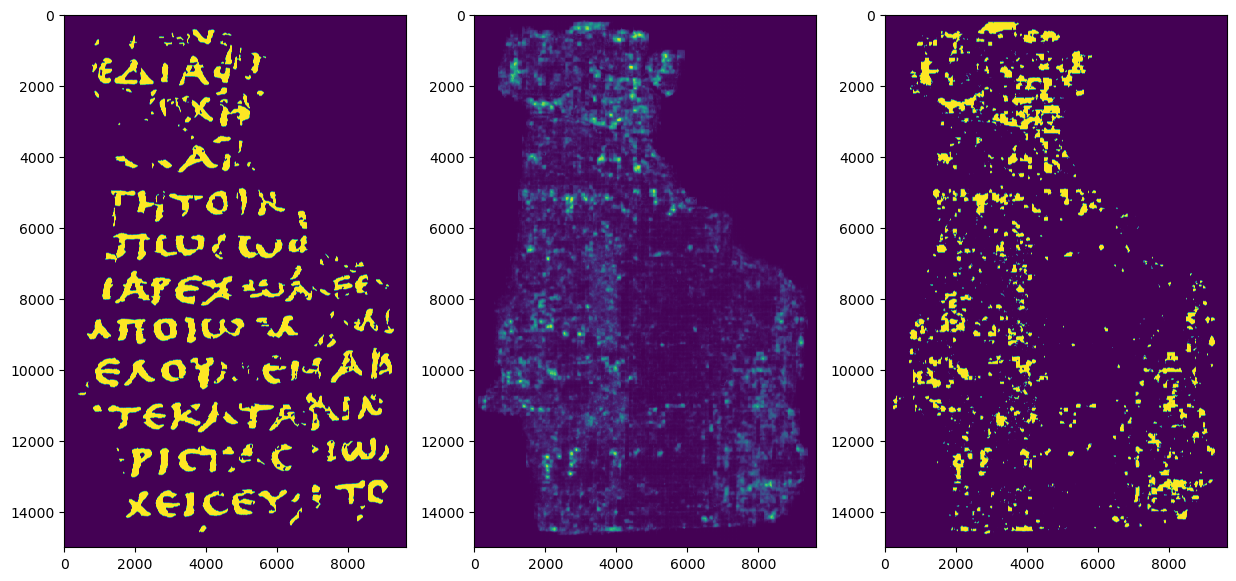

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([9.7868513e+07, 2.0395152e+07, 9.8109330e+06, 5.5114360e+06,
        3.4420720e+06, 2.2008460e+06, 1.4958070e+06, 1.0437710e+06,
        7.3609900e+05, 5.6566400e+05, 4.1146200e+05, 3.1644900e+05,
        2.3329600e+05, 1.7417000e+05, 1.2420600e+05, 9.6760000e+04,
        7.1250000e+04, 4.2387000e+04, 1.4589000e+04, 2.1940000e+03]),
 array([4.30116725e-05, 4.69114012e-02, 9.37797907e-02, 1.40648180e-01,
        1.87516570e-01, 2.34384959e-01, 2.81253349e-01, 3.28121738e-01,
        3.74990128e-01, 4.21858517e-01, 4.68726907e-01, 5.15595296e-01,
        5.62463686e-01, 6.09332075e-01, 6.56200465e-01, 7.03068854e-01,
        7.49937244e-01, 7.96805633e-01, 8.43674023e-01, 8.90542412e-01,
        9.37410802e-01]),
 <BarContainer object of 20 artists>)

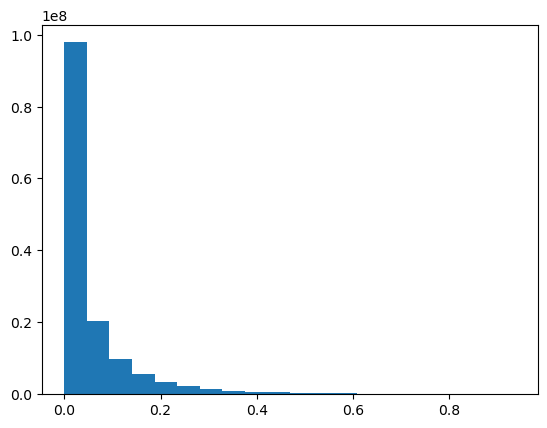

In [39]:
plt.hist(mask_pred.flatten(), bins=20)

In [40]:
# GPU VRAM 5.2GB/16.0GB A4000